In [ ]:
import yfinance as yf
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [251]:
def load_data(symbol, start_date, end_date):
    working_path = f"./data/{symbol}_{start_date}_{end_date}.csv"
    try:
        data = yf.download(symbol, start=start_date, end=end_date, interval="1wk")
        data.to_csv(working_path)
        return data
    except Exception as e:
        print(f"Error loading data for {symbol}: {e}")
        return None

In [360]:
asset_data = load_data("USDBRL=X", "2020-01-01", "2023-10-01")


/tmp/ipykernel_17941/2853163018.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date, interval="1wk")
[*********************100%***********************]  1 of 1 completed


In [361]:
asset_data.columns = asset_data.columns.droplevel(0)
asset_data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
print(asset_data.head())

             Close    High       Low      Open  Volume
Date                                                  
2020-01-01  4.0604  4.0906  4.000820  4.016786       0
2020-01-08  4.1458  4.1575  4.037521  4.066200       0
2020-01-15  4.1885  4.2052  4.110200  4.131300       0
2020-01-22  4.2061  4.2297  4.147400  4.210900       0
2020-01-29  4.2468  4.2842  4.181700  4.193300       0


In [362]:
asset_data["target"] = (asset_data["Close"].shift(-1) > asset_data["Close"]).astype(int)

<Axes: title={'center': 'Target Distribution'}, xlabel='target'>

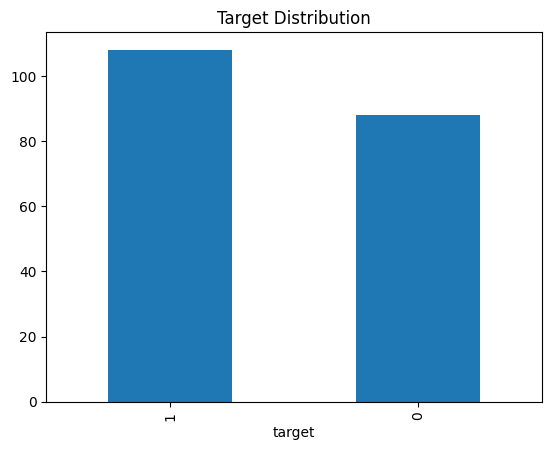

In [363]:
asset_data["target"].value_counts().plot(kind='bar', title='Target Distribution')

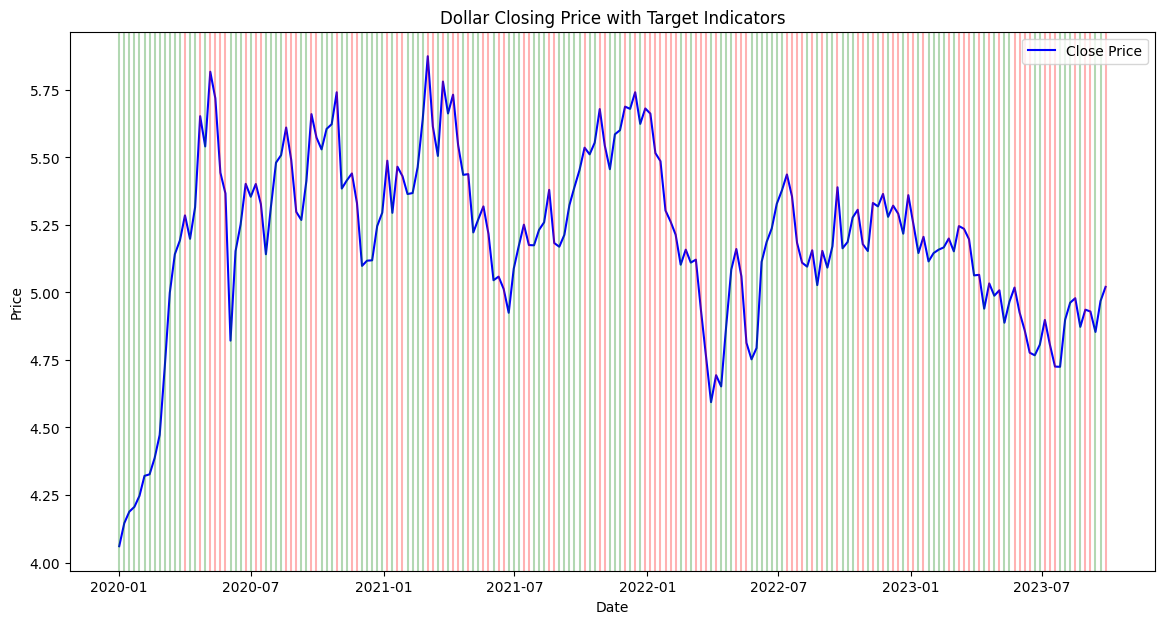

In [364]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=asset_data, x=asset_data.index, y="Close", label="Close Price", color="blue")

for i in range(len(asset_data)):
    color = "green" if asset_data["target"].iloc[i] == 1 else "red"
    plt.axvline(x=asset_data.index[i], color=color, alpha=0.3, linestyle="-")

plt.title("Dollar Closing Price with Target Indicators")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [365]:
asset_data["returns"] = asset_data["Close"].pct_change()
asset_data["volatility"] = asset_data["returns"].rolling(window=2).std()
asset_data["ma_4"] = asset_data["Close"].rolling(window=4).mean()
asset_data["ma_12"] = asset_data["Close"].rolling(window=12).mean()
asset_data["ma_ratio"] = asset_data["ma_4"] / asset_data["ma_12"]


In [ ]:
def plot_subplots(data, plots, figsize=(14, 15), sharex=True):
    fig, ax = plt.subplots(len(plots), 1, figsize=figsize, sharex=sharex)

    for i, plot in enumerate(plots):
        ax[i].plot(data.index, data[plot['column']], label=plot['label'], color=plot['color'])
        ax[i].set_title(plot['title'])
        ax[i].set_ylabel(plot['ylabel'])
        ax[i].legend()

    ax[-1].set_xlabel("Date")
    plt.show()


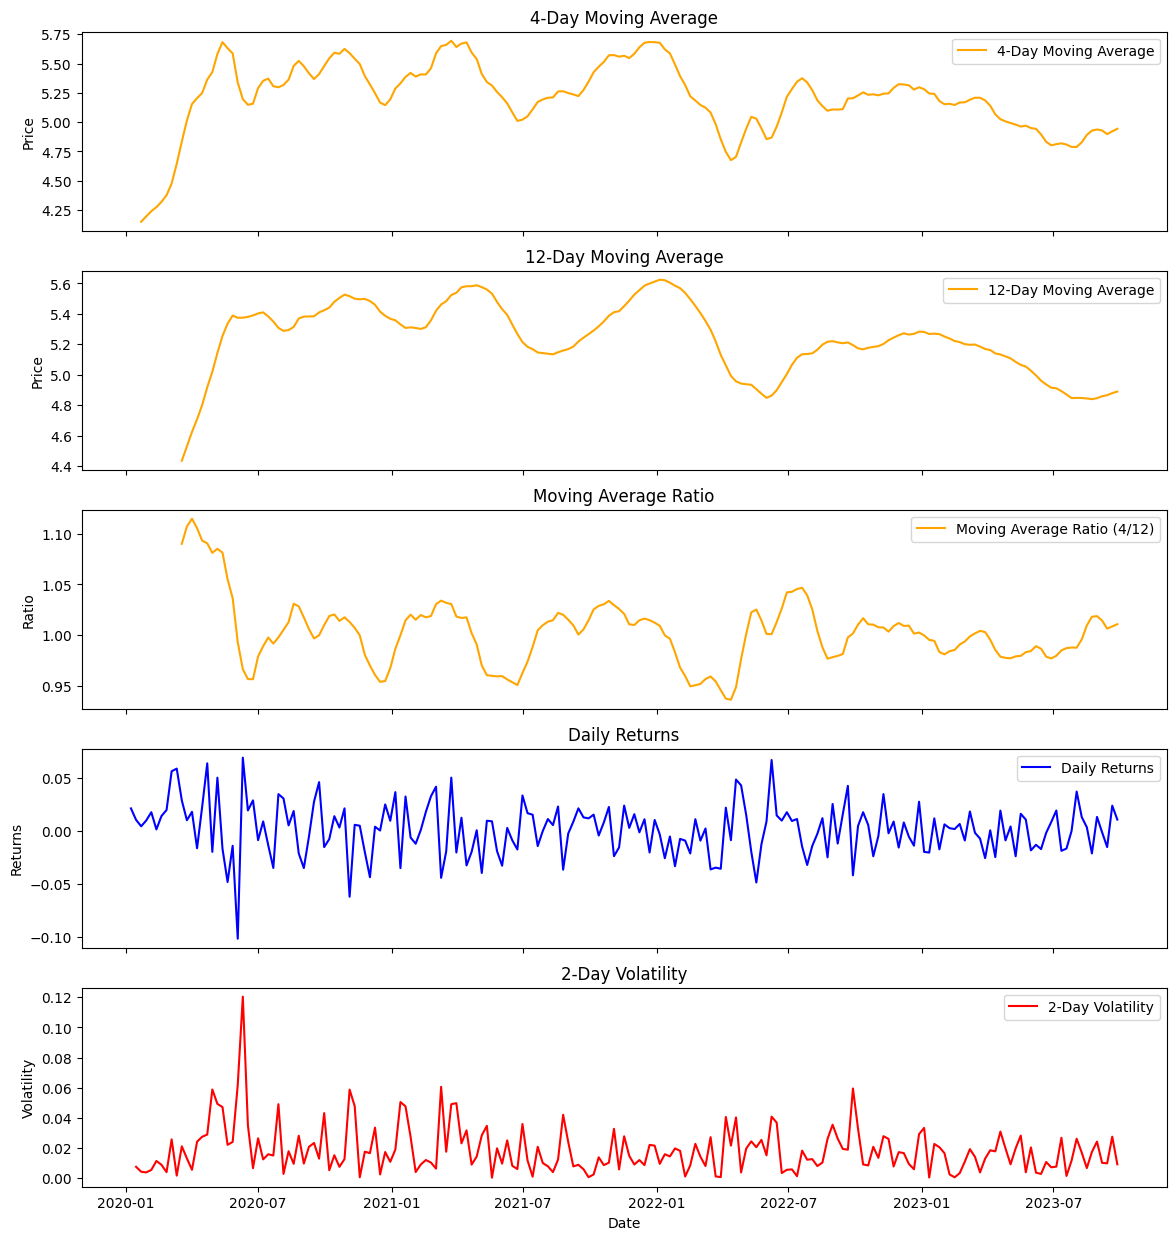

In [ ]:
plot_subplots(
    data=asset_data,
    plots=[
        {
            "column": "ma_4",
            "label": "4-Day Moving Average",
            "color": "orange",
            "title": "4-Day Moving Average",
            "ylabel": "Price"
        },
        {
            "column": "ma_12",
            "label": "12-Day Moving Average",
            "color": "orange",
            "title": "12-Day Moving Average",
            "ylabel": "Price"
        },
        {
            "column": "ma_ratio",
            "label": "Moving Average Ratio (4/12)",
            "color": "orange",
            "title": "Moving Average Ratio",
            "ylabel": "Ratio"
        },
        {
            "column": "returns",
            "label": "Daily Returns",
            "color": "blue",
            "title": "Daily Returns",
            "ylabel": "Returns"
        },
        {
            "column": "volatility",
            "label": "2-Day Volatility",
            "color": "red",
            "title": "2-Day Volatility",
            "ylabel": "Volatility"
        }
    ]
)

<Axes: >

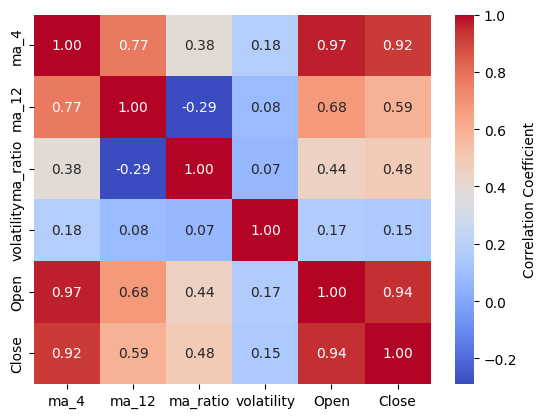

In [368]:
sns.heatmap(
    asset_data[["ma_4","ma_12", "ma_ratio", "volatility","Open", "Close"]].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={"label": "Correlation Coefficient"}
)

In [369]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [370]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression())
])

In [371]:

asset_data.dropna(inplace=True)
X = asset_data[["ma_ratio", "ma_4", "volatility", "Close"]]
y = asset_data["target"]

split_index = int(len(X) * 0.7)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [372]:
pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [373]:
predictions = pipeline.predict(X_test)
probas = pipeline.predict_proba(X_test)[:, 1]
predictions = (probas > 0.6).astype(int)

In [374]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, target_names=["Down", "Up"]))

              precision    recall  f1-score   support

        Down       0.64      0.50      0.56        28
          Up       0.59      0.71      0.65        28

    accuracy                           0.61        56
   macro avg       0.61      0.61      0.60        56
weighted avg       0.61      0.61      0.60        56



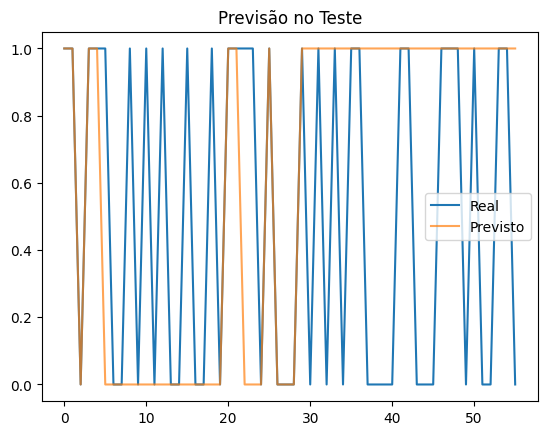

In [375]:
import matplotlib.pyplot as plt

plt.plot(y_test.values, label="Real")
plt.plot(predictions, label="Previsto", alpha=0.7)
plt.legend()
plt.title("Previsão no Teste")
plt.show()

In [376]:
all_predictions = pipeline.predict(X)
all_probas = pipeline.predict_proba(X)[:, 1]
all_predictions = (all_probas > 0.7).astype(int)

asset_data["predicted_target"] = all_predictions
asset_data["real_return"] = asset_data["returns"] * asset_data["predicted_target"]
asset_data.head()

,Close,High,Low,Open,Volume,target,returns,volatility,ma_4,ma_12,ma_ratio,predicted_target,real_return
Date,,,,,,,,,,,,,
2020-03-18,5.1417,5.2105,4.976100,5.009900,0,1,0.028546,0.021153,4.834000,4.434806,1.090014,1,0.028546
2020-03-25,5.1927,5.2040,4.973900,5.098600,0,1,0.009919,0.013171,5.014075,4.529165,1.107064,1,0.009919
2020-04-01,5.2853,5.3513,5.185842,5.203900,0,0,0.017833,0.005596,5.154675,4.624123,1.114736,0,0.000000
2020-04-08,5.1985,5.2447,5.050000,5.221600,0,1,-0.016423,0.024222,5.204550,4.708290,1.105401,0,-0.000000
2020-04-15,5.3154,5.3173,5.159709,5.160036,0,1,0.022487,0.027514,5.247975,4.800731,1.093162,0,0.000000


In [377]:
asset_data["cumulative_real_return"] = (1 + asset_data["returns"]).cumprod()
asset_data["cumulative_predicted_return"] = (1 + asset_data["real_return"]).cumprod()

In [378]:
def plot_cumulative_returns(data, real_column="cumulative_real_return", predicted_columns=None):
    if predicted_columns is None:
        predicted_columns = []

    plt.figure(figsize=(14, 7))

    plt.plot(data.index, data[real_column], label="Cumulative Real Return", color="blue")

    for column in predicted_columns:
        plt.plot(data.index, data[column], label=f"Cumulative Predicted Return ({column})", linestyle="--")

    plt.title("Comparison of Cumulative Real Return vs Predicted Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid()
    plt.show()


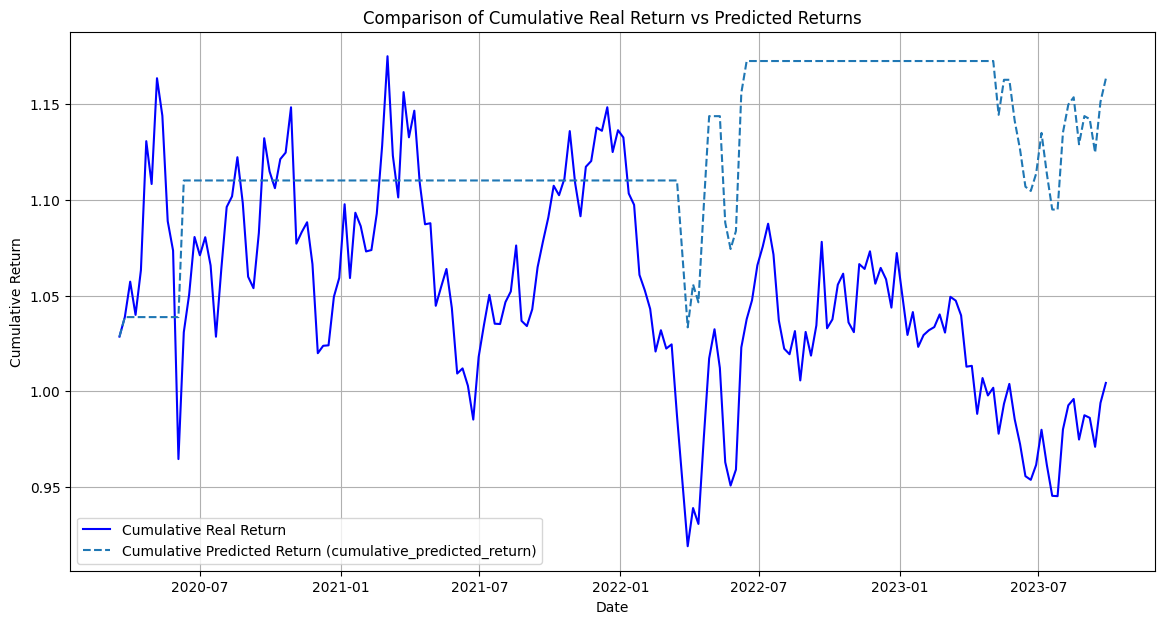

In [ ]:
plot_cumulative_returns(
    data=asset_data,
    real_column="cumulative_real_return",
    predicted_columns=["cumulative_predicted_return"]
)